# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [2]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

print(portfolio.shape)
portfolio.head(30)


(10, 6)


,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [4]:
print(profile.shape)
profile.head()


(17000, 5)


,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [5]:
print(transcript.shape)
transcript.head()


(306534, 4)


,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


# 1. Cleaning and Reorganizing the Datasets:

Our first task is to analyze each of the datasets individually and see in which of the variables we can wrangle and work around to get a better starting point for further analysys.

Let's start with the portfolio dataset:



In [6]:
## Portfolio Dataset:
#The idea here is to separate in different columns both the channels from where the offers are provided.
#Create a copy of the original portofolio dataframe to make the changes
df_pf= portfolio
#Organizing the sources for the offers, creating a dummy variable:
channel_dummies = pd.get_dummies(df_pf.channels.apply(pd.Series).stack()).sum(level=0)
df_pf = pd.concat([df_pf, channel_dummies], axis=1)
df_pf = df_pf.drop(columns='channels')

#Coming back to this point, we will also edit the id name into offer_id since we will also have the customer_id to make them different enough.
df_pf = df_pf.rename(columns={'id':'offer_id'})

df_pf.head()


,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


In [7]:
## Profile Dataset:
# For this dataset we want mainly want two things, one clarify the id here from the order id in the Portfolio dataset, 
# and second to obtain a more clear date on when the client became a member from it original format.

# Again, we start by creating a copy for the dataset to make the edits
df_prof= profile

# First we will range the ages between 16 and 90 years of age, just to eliminate the false info that can possibly skew the dataset.
#df_prof=df_prof[(df_prof['age']>=16) & (df_prof['age']<90)]

#In the same fashion as in the last dataset, editing the if column:
df_prof = df_prof.rename(columns={'id':'customer_id'})

#Finally editing the date format:
df_prof['became_member_on'] = pd.to_datetime(df_prof['became_member_on'].astype(str), format='%Y%m%d')

df_prof.head()



,age,became_member_on,gender,customer_id,income
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [8]:
## Transcript Dataset:
#In this case, similarly to the portfolio dataset, we need to create new columns for the event column, to separate it into ransaction, offer received, offer viewed.
df_t= transcript
event_dummies= pd.get_dummies(df_t['event'])
df_t = pd.concat([df_t, event_dummies], axis=1)
df_t = df_t.drop(columns='event')
# The column value needs some editing, dividing it into two subcolumns as well:
# I tried this code earlier but then realized it is needed to split the column, since there is a dictionary.
#df_t['value']=df_t['value'].astype(str).str.replace(r"{'offer id': '", "").str.replace("'}", "")

df_t['offer_id']=[[*i.values()][0]if [*i.keys()][0] in ['offer id','offer_id'] else None for i in df_t.value]
df_t['amount']= [[*i.values()][0] if [*i.keys()][0] == 'amount' else None for i in df_t.value]
df_t = df_t.drop(columns='value')
df_t = df_t.rename(columns={'person':'customer_id'})


df_t.head()

,customer_id,time,offer completed,offer received,offer viewed,transaction,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [9]:
#Since we have the common customer id in the transcript and profile datasets we can mix them:
df_mix= pd.merge(df_prof,df_t, on='customer_id')
df_mix.head()

,age,became_member_on,gender,customer_id,income,time,offer completed,offer received,offer viewed,transaction,offer_id,amount
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,168,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
1,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,216,0,0,1,0,2906b810c7d4411798c6938adc9daaa5,NaN
2,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,336,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
3,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,348,0,0,1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
4,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,360,0,0,0,1,None,0.35


# 2. Exploratory analysis and Visualization

Once we have the datasets properly organized it is time to make some preliminary investigations, just to understand better the data we are working with. 
Then, based on this information it is time to make some decisions on how we want to continue further studies, whether it is using predictive models, statistical regressions or even Neural Networks or other techniques.

# 2.1 Demographics:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 12 columns):
age                 306534 non-null int64
became_member_on    306534 non-null datetime64[ns]
gender              272762 non-null object
customer_id         306534 non-null object
income              272762 non-null float64
time                306534 non-null int64
offer completed     306534 non-null uint8
offer received      306534 non-null uint8
offer viewed        306534 non-null uint8
transaction         306534 non-null uint8
offer_id            167581 non-null object
amount              138953 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(2), object(3), uint8(4)
memory usage: 22.2+ MB


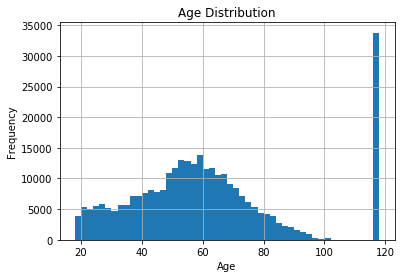

There are : 33772 inputs of people being 118 years old, which is probably a wrong input/missing data


In [11]:
#Let's start with the df_mix we just created:
df_mix.info()

#Taking a look into the age column:
df_mix.age.describe()
df_mix.age.hist(bins = 50)

plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')

# Show the plot
plt.show()
too_old_count=(df_mix['age']==118).sum()
print('There are :', too_old_count, 'inputs of people being 118 years old, which is probably a wrong input/missing data')

#The age column has a pretty standard shape, although I personally expected it to be more skewed towards young people since starbucks is a chain usually more popular in younger generations.
#There are almost 10% of the age counts with value of 118 which does not really make sense, but it should not make a difference for further investigations. If we plan a model based on age conditions this cases will be not taken into account.


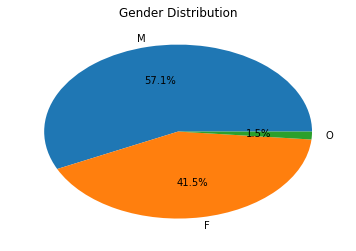

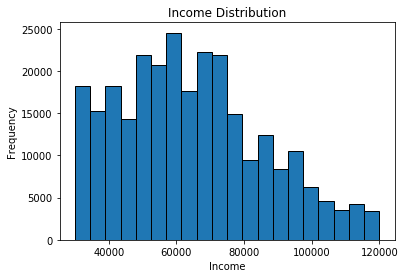

count    272762.000000
mean      64337.000755
std       21243.762941
min       30000.000000
25%       48000.000000
50%       62000.000000
75%       78000.000000
max      120000.000000
Name: income, dtype: float64


In [9]:
#We can also take a deeper look into the demographics,by looking at the income and the gender distribution on the data:
gender_counts = df_mix['gender'].value_counts(normalize=True) * 100
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%')
plt.title('Gender Distribution')
plt.show()
#The results in here are pretty self explanatory, with 57% of the data being males and 41.5% females, with only 1.5% considered as "other".

#The income column needs a little cleaning, due to the NaN values
income_without_nan = df_mix['income'].dropna()

plt.hist(income_without_nan, bins=20, edgecolor='black')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.title('Income Distribution')
plt.show()

print(income_without_nan.describe())

#The average income is in the 60k range, with a std deviation of around 21k.


# 2.2 Offer related Variables:

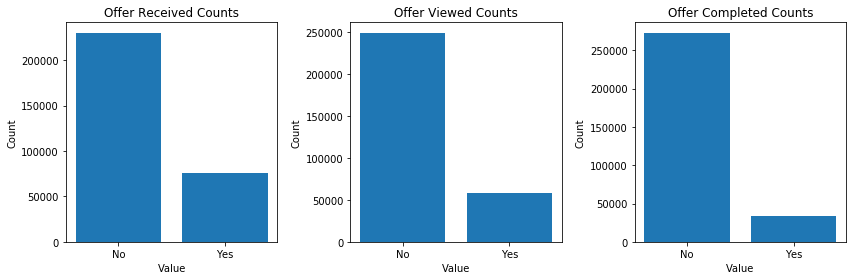

Proportion of 'Yes' values in Offer Received: 24.88%
Proportion of 'Yes' values in Offer Viewed: 18.83%
Proportion of 'Yes' values in Offer Completed: 10.95%


In [10]:
#The idea in this part is to dive deeper into the amount of offers every customer receives, how they are received and such insights.

#Starting by the received, viewed and completed parameters:
offer_received_counts=df_mix['offer received'].value_counts()
offer_viewed_counts=df_mix['offer viewed'].value_counts()
offer_completed_counts=df_mix['offer completed'].value_counts()

# Calculate proportions
offer_received_proportion = offer_received_counts[1] / offer_received_counts.sum()
offer_viewed_proportion = offer_viewed_counts[1] / offer_viewed_counts.sum()
offer_completed_proportion = offer_completed_counts[1] / offer_completed_counts.sum()

#Plots and Visualization:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Bar plot for offer_received_counts
axes[0].bar(['No', 'Yes'], offer_received_counts.values)
axes[0].set_title('Offer Received Counts')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Count')

# Bar plot for offer_viewed_counts
axes[1].bar(['No', 'Yes'], offer_viewed_counts.values)
axes[1].set_title('Offer Viewed Counts')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Count')

# Bar plot for offer_completed_counts
axes[2].bar(['No', 'Yes'], offer_completed_counts.values)
axes[2].set_title('Offer Completed Counts')
axes[2].set_xlabel('Value')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

# Print proportions
print("Proportion of 'Yes' values in Offer Received: {:.2%}".format(offer_received_proportion))
print("Proportion of 'Yes' values in Offer Viewed: {:.2%}".format(offer_viewed_proportion))
print("Proportion of 'Yes' values in Offer Completed: {:.2%}".format(offer_completed_proportion))




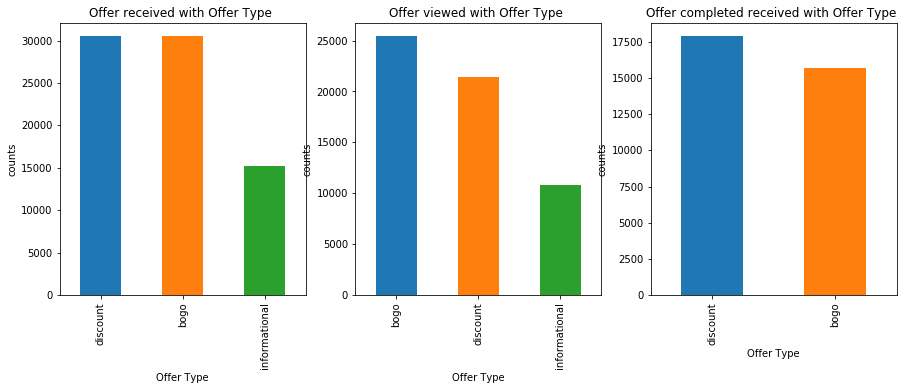

Proportion of 'bogo' offers completed over received: 51.38%
Proportion of 'bogo' offers completed over viewed: 61.57%
Proportion of 'discount' offers completed over received: 58.64%
Proportion of 'discount' offers completed over viewed: 83.52%


In [12]:
#Now, looking at the data where the result was 'Yes':
#We can also merge all the info from the datasets and cross the amount of offers completed based on the type of offer (bogo, discounts..)
all_data = pd.merge(df_pf, df_mix, on='offer_id')
all_data['income'].dropna()

#Obtain the values based on the offer type:
offer_received = all_data[all_data['offer received'] == 1].offer_type.value_counts()
offer_viewed = all_data[all_data['offer viewed'] == 1].offer_type.value_counts()
offer_completed = all_data[all_data['offer completed'] == 1].offer_type.value_counts()

#Plotting:
plt.subplot(131)
offer_received = all_data[all_data['offer received'] == 1].offer_type.value_counts()
offer_received.plot(kind='bar', figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Type')
plt.title('Offer received with Offer Type ');

plt.subplot(132)
offer_viewed = all_data[all_data['offer viewed'] == 1].offer_type.value_counts()
offer_viewed.plot(kind='bar' , figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Type')
plt.title('Offer viewed with Offer Type ');

plt.subplot(133)
offer_completed = all_data[all_data['offer completed'] == 1].offer_type.value_counts()
offer_completed.plot(kind='bar' , figsize=(15,5))
plt.ylabel('counts')
plt.xlabel('Offer Type')
plt.title('Offer completed received with Offer Type ');

plt.show()

# Calculate the proportions
bogo_completed_proportion_received = offer_completed['bogo'] / offer_received['bogo']
bogo_completed_proportion_viewed = offer_completed['bogo'] / offer_viewed['bogo']
discount_completed_proportion_received = offer_completed['discount'] / offer_received['discount']
discount_completed_proportion_viewed = offer_completed['discount'] / offer_viewed['discount']

# Print the proportions
print("Proportion of 'bogo' offers completed over received: {:.2%}".format(bogo_completed_proportion_received))
print("Proportion of 'bogo' offers completed over viewed: {:.2%}".format(bogo_completed_proportion_viewed))
print("Proportion of 'discount' offers completed over received: {:.2%}".format(discount_completed_proportion_received))
print("Proportion of 'discount' offers completed over viewed: {:.2%}".format(discount_completed_proportion_viewed))

In [13]:
print(all_data.shape)
all_data.head(20)

(167581, 20)


,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web,age,became_member_on,gender,customer_id,income,time,offer completed,offer received,offer viewed,transaction,amount
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,408,0,1,0,0,NaN
1,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,408,0,0,1,0,NaN
2,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,510,1,0,0,0,NaN
3,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,118,2017-10-02,None,68617ca6246f4fbc85e91a2a49552598,NaN,168,0,1,0,0,NaN
4,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,118,2017-08-24,None,c4863c7985cf408faee930f111475da3,NaN,576,0,1,0,0,NaN
5,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,118,2017-08-24,None,c4863c7985cf408faee930f111475da3,NaN,684,0,0,1,0,NaN
6,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,118,2017-08-24,None,c4863c7985cf408faee930f111475da3,NaN,684,1,0,0,0,NaN
7,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,118,2015-09-19,None,148adfcaa27d485b82f323aaaad036bd,NaN,336,0,1,0,0,NaN
8,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,118,2015-09-19,None,148adfcaa27d485b82f323aaaad036bd,NaN,336,0,0,1,0,NaN
9,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,61,2017-09-11,F,aa4862eba776480b8bb9c68455b8c2e1,57000.0,408,0,1,0,0,NaN


count    138953.000000
mean         12.777356
std          30.250529
min           0.050000
25%           2.780000
50%           8.890000
75%          18.070000
max        1062.280000
Name: amount, dtype: float64


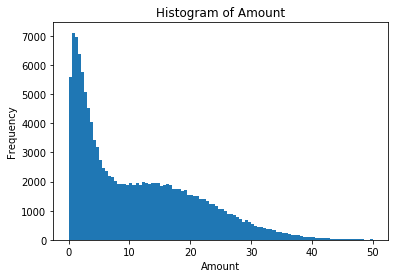

In [14]:
filtered_amount = df_mix['amount'].dropna()
print(filtered_amount.describe())

# Create a histogram
plt.hist(filtered_amount, bins=100, range=(0,50))  # You can adjust the number of bins as per your preference

# Add labels and title
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.title('Histogram of Amount')

# Show the histogram
plt.show()

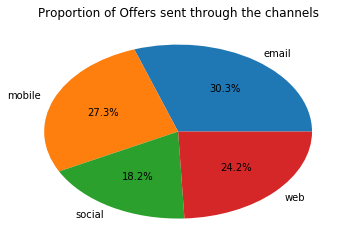

In [15]:
#We want to look into the complete dataset before going deeper into more complex relationships between variables, so looking at the profile dataset:

counts_sources = df_pf[['email', 'mobile', 'social', 'web']].apply(pd.value_counts).loc[1]
counts_sources.plot.pie(autopct='%1.1f%%')
plt.title('Proportion of Offers sent through the channels')
plt.ylabel('')
plt.show()
#The graph previously shown is representing which of the categories are more used as the way to share the offers with the customers.





## 3. Modelling and Deeper Analysis:

So, after the initial understanding of the datasets we are working with we arrived at seeing a good overview on what info we have, the customers attributes and the posible insights we are looking for.
Despite the complexity of the information we have available i want to dive further into the relationship between demographics and the kind of offers that are more suitable to the customers based on it.

For the modelling we will start with a model as simple as posible and evaluate the results obtained with it, before diving into more complex challenges or models where we can find ourselves with problems such as overfitting or the need for more computational resources. We will use a regression model.


In [19]:
all_data.head(20)

,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web,age,became_member_on,gender,customer_id,income,time,offer completed,offer received,offer viewed,transaction,amount
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,408,0,1,0,0,NaN
1,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,408,0,0,1,0,NaN
2,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,510,1,0,0,0,NaN
3,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,118,2017-10-02,None,68617ca6246f4fbc85e91a2a49552598,NaN,168,0,1,0,0,NaN
4,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,118,2017-08-24,None,c4863c7985cf408faee930f111475da3,NaN,576,0,1,0,0,NaN
5,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,118,2017-08-24,None,c4863c7985cf408faee930f111475da3,NaN,684,0,0,1,0,NaN
6,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,118,2017-08-24,None,c4863c7985cf408faee930f111475da3,NaN,684,1,0,0,0,NaN
7,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,118,2015-09-19,None,148adfcaa27d485b82f323aaaad036bd,NaN,336,0,1,0,0,NaN
8,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,118,2015-09-19,None,148adfcaa27d485b82f323aaaad036bd,NaN,336,0,0,1,0,NaN
9,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,61,2017-09-11,F,aa4862eba776480b8bb9c68455b8c2e1,57000.0,408,0,1,0,0,NaN


In [16]:
## 3.1 Data split and Model Training:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score


scaler = StandardScaler()

# Identify categorical columns for one-hot encoding
categorical_cols = ['gender', 'offer_type']

# Identify numerical columns for scaling
numerical_cols = ['age', 'income', 'reward', 'difficulty']

# Replace zero values in 'income' with the mean value
all_data['income'] = all_data['income'].replace(0, all_data['income'][all_data['income'] > 0].mean())

# Handle missing values
all_data.fillna(0, inplace=True)

# Handle infinite values
all_data.replace([np.inf, -np.inf], 0, inplace=True)

# Preprocess categorical columns with one-hot encoding
X_categorical = pd.get_dummies(all_data[categorical_cols], drop_first=True)

# Concatenate one-hot encoded categorical columns with numerical columns
X = pd.concat([all_data[numerical_cols], X_categorical], axis=1)
y = all_data['offer completed']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical columns
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Train the model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))





/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing

Accuracy: 0.726198645463
Classification Report:
              precision    recall  f1-score   support

          0       0.79      0.90      0.84     26796
          1       0.03      0.01      0.02      6721

avg / total       0.63      0.73      0.68     33517



Looking at the results we can take away some of these keypoints:
    
    1. The model has high precision for the negative class (class 0), indicating that when it predicts an offer not completed, it is correct about 79% of the time.
    
    2. However, the recall for the positive class (class 1) is very low (2%), indicating that the model is not identifying a significant portion of the offers that are actually completed.
    
    3. The low F1-score for class 1 suggests that the model is struggling to find a balance between precision and recall for the positive class.
    
Now we can try again adding some new parameters and recheck the outcome.

In [18]:
## 3.2 Second Iteration:

scaler = StandardScaler()

# Identify categorical columns for one-hot encoding
categorical_cols = ['gender', 'offer_type']

# Identify numerical columns for scaling
numerical_cols = ['age', 'income', 'reward', 'difficulty', 'duration', 'offer received']

# Replace zero values in 'income' with the mean value
all_data['income'] = all_data['income'].replace(0, all_data['income'][all_data['income'] > 0].mean())

# Handle missing values
all_data.fillna(0, inplace=True)

# Handle infinite values
all_data.replace([np.inf, -np.inf], 0, inplace=True)

# Preprocess categorical columns with one-hot encoding
X_categorical = pd.get_dummies(all_data[categorical_cols], drop_first=True)

# Concatenate one-hot encoded categorical columns with numerical columns
X = pd.concat([all_data[numerical_cols], X_categorical], axis=1)
y = all_data['offer completed']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical columns
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Train the model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing

Accuracy: 0.705612077453
Classification Report:
              precision    recall  f1-score   support

          0       0.81      0.83      0.82     26796
          1       0.25      0.23      0.24      6721

avg / total       0.70      0.71      0.70     33517



In [22]:
## 3.3 Third Iteration:
#In this last model we are going to see the differnece, if there is any between the offer received or offer viewed column.

scaler = StandardScaler()

# Identify categorical columns for one-hot encoding
categorical_cols = ['gender', 'offer_type']

# Identify numerical columns for scaling
numerical_cols = ['age', 'income', 'reward', 'difficulty', 'duration', 'offer viewed']

# Replace zero values in 'income' with the mean value
all_data['income'] = all_data['income'].replace(0, all_data['income'][all_data['income'] > 0].mean())

# Handle missing values
all_data.fillna(0, inplace=True)

# Handle infinite values
all_data.replace([np.inf, -np.inf], 0, inplace=True)

# Preprocess categorical columns with one-hot encoding
X_categorical = pd.get_dummies(all_data[categorical_cols], drop_first=True)

# Concatenate one-hot encoded categorical columns with numerical columns
X = pd.concat([all_data[numerical_cols], X_categorical], axis=1)
y = all_data['offer completed']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical columns
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Train the model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing

Accuracy: 0.66396157174
Classification Report:
              precision    recall  f1-score   support

          0       0.78      0.80      0.79     26796
          1       0.12      0.10      0.11      6721

avg / total       0.65      0.66      0.66     33517



# 4 Conclusions:

In the pursuit of developing a machine learning model to predict whether an offer is completed, we undertook three iterations, focusing on refining the predictive capabilities, particularly for the positive class.

    First Iteration:
        Accuracy: 0.726
        Observations:
        The model showcased effectiveness in predicting instances where the offer was not completed (class 0).
        However, its performance in predicting completed offers (class 1) was suboptimal, reflected by low precision, recall, and F1-score.
    Second Iteration:
        Accuracy: 0.706
        Changes Made:
        Two extra parameters were introduced.
        Observations:
        The incorporation of additional parameters contributed to a slight enhancement in the model's ability to predict completed offers.
        Despite this improvement, challenges persisted in providing satisfactory results for completed offers.
    Third Iteration:
        Accuracy: 0.664
        Changes Made:
        The parameter 'offer received' was replaced with 'offer viewed.'
        Observations:
        The modification negatively impacted the model's predictive performance, particularly for completed offers.
        
The model consistently excelled in identifying instances where the offer was not completed (class 0) but encountered difficulties in accurately predicting completed offers (class 1).
In summary, while our model demonstrated satisfactory accuracy, improvements are essential, especially in predicting completed offers, maybe a broader and more balanced dataset we could achieve a better result prognosis.

Further iterations involving careful feature engineering, hyperparameter tuning, and potentially exploring alternative algorithms could be also a deciding factor for it.